# Model 3: Style Transfer with Autoencoder + WCT Transform

The 3rd model is different from the previous 2 models, which minimises the loss of style & content w.r.t combined image. This model uses a pre-trained autoencoder trained by the original author of the paper, [Universal Style Transfer via Feature Transforms](https://arxiv.org/pdf/1705.08086.pdf), which is the basis of this model. The autoencoder is trained to minimise the loss of content and style, hence no futher optimising is required. Instead, only WCT (Whitening & Color Transfer) inbetween the encoding & decoding process is required to achieve the final styel transfer with this method. 


In [1]:
#Import libraries
import keras.backend as K
from keras.models import Model
from keras.applications import vgg19
from keras.layers import Input, Conv2D, UpSampling2D, Activation, Lambda, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array

import torchfile

import tensorflow as tf
from tensorflow.python.layers import utils

import scipy.misc

import numpy as np
import cv2 as cv

from PIL import Image
import matplotlib.pyplot as plt

#Functions from WCT_Function.py
from WCT_Function import encoder1_1, encoder2_1, encoder3_1, encoder4_1, encoder5_1, decoder1_1, decoder2_1, decoder3_1, decoder4_1, decoder5_1, wct_tf

Using TensorFlow backend.


In [2]:
#Define function to preprocess image
def preprocess_image(image_path, img_height, img_width, width, height):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  top = int(0.0014 * width)  # shape[0] = rows
  bottom = top
  left = int(0.0014 * height)  # shape[1] = cols
  right = left
  #img = cv.copyMakeBorder(img, top, bottom, left, right, cv.BORDER_CONSTANT, None, [255,255,255])
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

#Define function to deprocess image
def deprocess_image(x, hcrop, wcrop,scale_percent):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  x = x[int(hcrop*x.shape[0]):int((1-hcrop)*x.shape[0]),int(wcrop*x.shape[1]):int((1-wcrop)*x.shape[1])]
  width = int(x.shape[1] * scale_percent / 100)
  height = int(x.shape[0] * scale_percent / 100)
  dim = (width, height)
  x = cv.resize(x, dim, interpolation = cv.INTER_AREA)
  return x

## Read and Load Images

In [3]:
#Content image
target_image_path = './img/shophouse.jpg'
#Style image
style_reference_image_path = './img/wgz3.jpg'
#Find width & height of content image
width, height = load_img(target_image_path).size

#Limit maximum size of images ot be 512
resize = 512
if height < width:
    ratio = height / resize
    img_width = int(width / ratio)
    img_height = resize
else:
    ratio = width / resize
    img_height = round(height / ratio)
    img_width  = resize

## Running Neural Style Transfer with WCT

In [4]:
#Initialising Content and Style images
content_img = preprocess_image(target_image_path, img_height, img_width, width, height)
style_img = preprocess_image(style_reference_image_path, img_height, img_width, width, height)

#Set constant alpha (0-1). Higher alpha equals to more weight on style.
a = 0.8

![wct flowchart](./img/WCT_img/wctmodel_flowchart.png)

The WCT model will be ran with the following flow, from Relu5_1 encode & decoder to Relu1_1 to generate the final output image.

### Relu 5_1

In [0]:
#Assign encoder 5_1, which encode with VGG19 relu5_1 layer
encode5 = encoder5_1()
fc = encode5.predict(content_img)
fs = encode5.predict(style_img)

#wct transform
wct = wct_tf(fc,fs, alpha=a)

#Convert output from tensor to array
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
with sess.as_default():
  wct = wct.eval()
sess.close() 

#Decode wct transformed output with inverted VGG relu5_1 layer
decode5 = decoder5_1()
dc5 = decode5.predict(wct)

### Relu 4_1

In [0]:
#Assign encoder 4_1, which encode with VGG19 relu4_1 layer
encode4 = encoder4_1()
fc = encode4.predict(dc5)
fs = encode4.predict(style_img)

#wct transform
wct = wct_tf(fc,fs, alpha=a)

#Convert output from tensor to array
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
with sess.as_default():
    wct = wct.eval()
sess.close() 

#Decode wct transformed output with inverted VGG relu4_1 layer
decode4 = decoder4_1()
dc4 = decode4.predict(wct)

### Relu 3_1

In [0]:
#Assign encoder 3_1, which encode with VGG19 relu3_1 layer
encode3 = encoder3_1()
fc = encode3.predict(dc4)
fs = encode3.predict(style_img)

#wct transform
wct = wct_tf(fc,fs, alpha=a)

#Convert output from tensor to array
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
with sess.as_default():
    wct = wct.eval()
sess.close() 

#Decode wct transformed output with inverted VGG relu3_1 layer
decode3 = decoder3_1()
dc3 = decode3.predict(wct)

### Relu 2_1

In [0]:
#Assign encoder 2_1, which encode with VGG19 relu2_1 layer
encode2 = encoder2_1()
fc = encode2.predict(dc3)
fs = encode2.predict(style_img)

#wct transform
wct = wct_tf(fc,fs, alpha=a)

#Convert output from tensor to array
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
with sess.as_default():
    wct = wct.eval()
sess.close() 

#Decode wct transformed output with inverted VGG relu2_1 layer
decode2 = decoder2_1()
dc2 = decode2.predict(wct)

### Relu 1_1

In [0]:
#Assign encoder 1_1, which encode with VGG19 relu1_1 layer
encode1 = encoder1_1()
fc = encode1.predict(dc2)
fs = encode1.predict(style_img)

#wct transform
wct = wct_tf(fc,fs, alpha=a)

#Convert output from tensor to array
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
with sess.as_default():
    wct = wct.eval()
sess.close() 

#Decode wct transformed output with inverted VGG relu2_1 layer
decode1 = decoder1_1()
dc1 = decode1.predict(wct)

## Saving Result

In [0]:
#Remove the 1st tensor dimension to keep dim at 3
final = tf.squeeze(dc1)

#convert from tensor to array
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
with sess.as_default():
    final = final.eval()
sess.close() 

#Deprocess final output
img = deprocess_image(final,0.17,0.12,100)

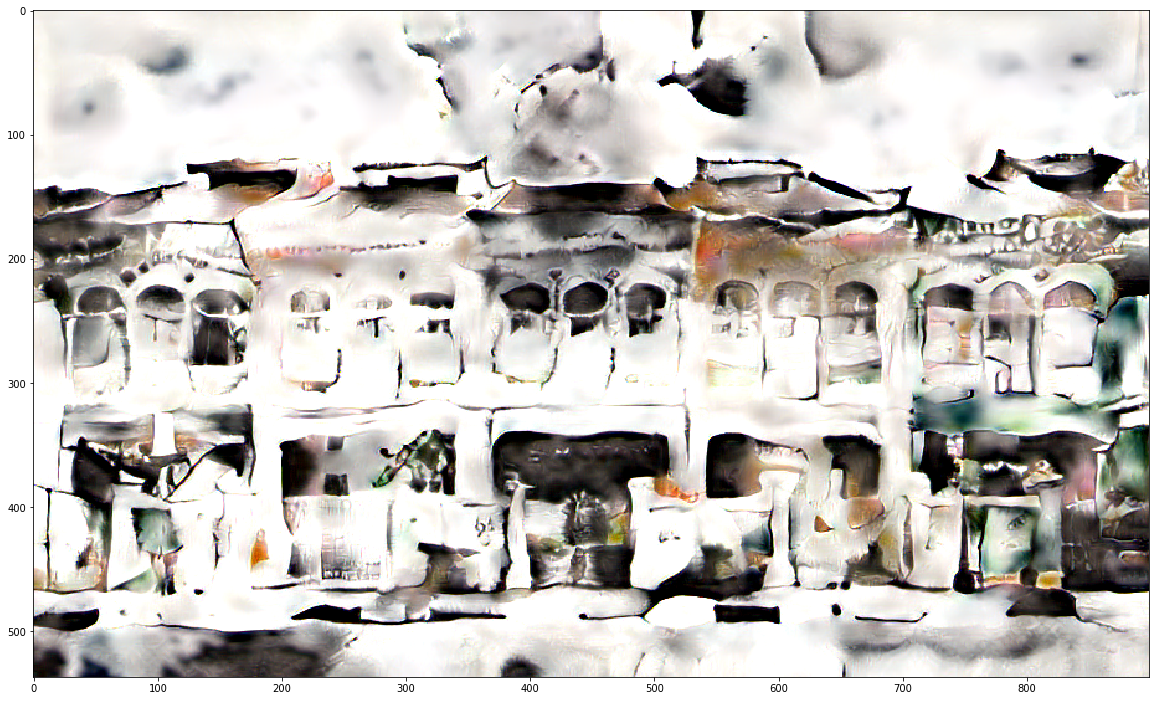

In [0]:
#plot final image
plt.figure(figsize=(20,20))
plt.imshow(img)

In [0]:
# save the image
plt.imsave('./img/WCT_img/NST04_shtest.png', img)